In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys

from skimage.io import imread
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *

In [2]:
url = 'http://github.com/dknife/ML/raw/main/data/Proj2/faces/'

face_images = []

for i in range(15):
  file = url + 'img{0:02d}.jpg'.format(i+1)
  img = imread(file)
  img = resize(img,(64,64))

  face_images.append(img)
  
  
url = 'https://github.com/dknife/ML/raw/main/data/Proj2/animals/'
animal_images = []

for i in range(15):
  file = url + 'img{0:02d}.jpg'.format(i+1)
  img = imread(file)
  img = resize(img, (64,64))
  animal_images.append(img)
  
  
url = 'https://github.com/dknife/ML/raw/main/data/Proj2/test_data/'
test_images = []
for i in range(10):
  file = url + 'img{0:02d}.jpg'.format(i+1)
  img = imread(file)
  img = resize(img, (64,64))
  test_images.append(img)

<Figure size 640x480 with 0 Axes>

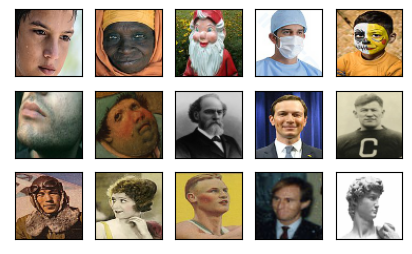

<Figure size 640x480 with 0 Axes>

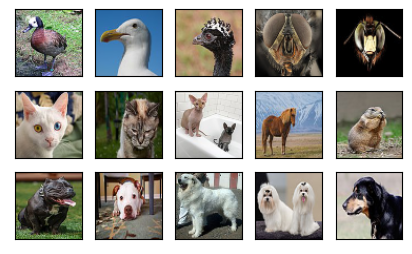

<Figure size 640x480 with 0 Axes>

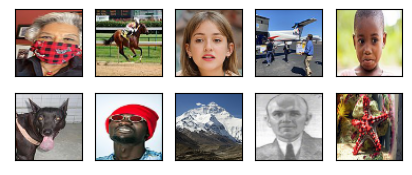

In [3]:
def plot_images(nRow, nCol, img):
  fig = plt.figure()
  fig, ax = plt.subplots(nRow, nCol, figsize = (nCol, nRow))
  for i in range(nRow):
    for j in range(nCol):
      if nRow <=1:axis = ax[j]
      else: axis = ax[i, j]
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
      axis.imshow(img[i*nCol+j])

plot_images(3,5,face_images)
plot_images(3, 5, animal_images)
plot_images(2, 5, test_images)


In [4]:
X_train, y_train = [], []

for feature in face_images:
  X_train.append(feature)
  y_train.append(1)
for feature in animal_images:
  X_train.append(feature)
  y_train.append(0)

print(len(X_train), len(y_train))
print(y_train)

  
X_test, y_test = [], []

for i, feature in enumerate(test_images):
  X_test.append(feature)
  y_test.append(1 if i % 2 == 0 else 0) 
  
print(len(X_test), len(y_test))
print(y_test)

30 30
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
10 10
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


In [5]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

le = LabelEncoder()
y_train = to_categorical(le.fit_transform(y_train))
y_test = to_categorical(le.fit_transform(y_test))

print('train:', X_train.shape, y_train.shape)
print('test:', X_test.shape, y_test.shape)

train: (30, 64, 64, 3) (30, 2)
test: (10, 64, 64, 3) (10, 2)


In [6]:
# 파라미터
CLASS_COUNT=2
EPOCHS=50
BATCH_SIZE=2048
num_rows, num_columns, num_channels = 64, 64, 3
loss="binary_crossentropy"
lr=1e-4
PATIENCE=50

In [7]:
# 로스, 정확도 그래프 출력
def plot_loss_accuracy(history):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))

        plt.figure(1)
        plt.plot(epochs, acc, 'b', label='Training accuracy')
        plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure(2)
        plt.plot(epochs, loss, 'b', label='Training Loss')
        plt.plot(epochs, val_loss, 'r', label='Validation Loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()


# 모델 셋팅
def setting(model, x_train, y_train, x_test, y_test):
        checkpoint=ModelCheckpoint(filepath='./Saved_Model/' + sys._getframe(1).f_code.co_name + '_Weight_best.hdf5', monitor="val_loss",
                                verbose=1, save_best_only=True)

        ealrystopping=EarlyStopping(monitor="val_loss", patience=PATIENCE)

        model.summary()

        history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test, y_test),
                        callbacks=[checkpoint, ealrystopping], verbose=1)
        
        plot_loss_accuracy(history)
        
# 결과 확인
def result(x_test, y_test, model_name):
    model = load_model('./Saved_Model/' + model_name + '_Weight_best.hdf5')
    print('accuracy :', model.evaluate(x_test, y_test, verbose=0)[1])
    
    result = model.predict(x_test)
    y_pred = [np.argmax(result[i]) for i in range(result.shape[0])]

    print(y_pred)
    
    fig = plt.figure()
    fig, ax = plt.subplots(2,5, figsize = (10,4))
    for i in range(2):
        for j in range(5):
            ax[i, j].get_xaxis().set_visible(False)
            ax[i, j].get_yaxis().set_visible(False)
            if y_pred[i*5+j] == 1:
                ax[i, j].imshow(test_images[i*5+j], interpolation='nearest')


In [8]:
def face_net(x_train, y_train, x_test, y_test):
    inputs = Input(shape=(num_rows, num_columns, num_channels))
    conv = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding="same", activation='relu')(inputs)
    maxpoll = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding="valid")(conv)
    flat = Flatten()(maxpoll)
    fc = Dense(32, activation='relu')(flat)
    outputs = Dense(CLASS_COUNT, activation='sigmoid')(fc)

    model = Model(inputs, outputs)
    
    model.compile(loss="binary_crossentropy",
            metrics=["accuracy"], optimizer=Adam(learning_rate=lr))

    return setting(model, x_train, y_train, x_test, y_test)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 127008)            0         
                                                                 
 dense (Dense)               (None, 32)                4064288   
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                             

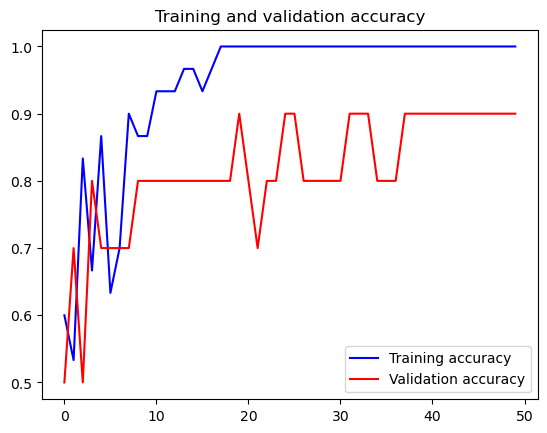

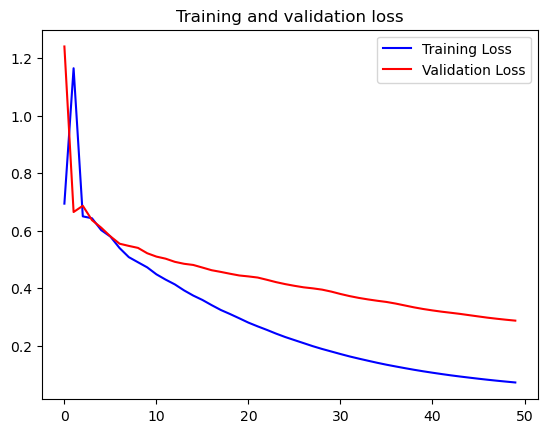

In [9]:
face_net(X_train, y_train, X_test, y_test)

accuracy : 0.8999999761581421
[1, 0, 1, 0, 1, 1, 1, 0, 1, 0]


<Figure size 640x480 with 0 Axes>

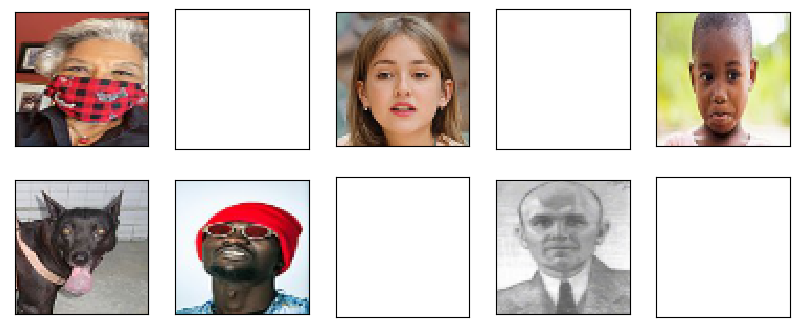

In [10]:
result(X_test, y_test, 'face_net')